# **Import Required Libraries**

In [1]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
from torchvision import models

from PIL import Image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# **Download and Extract the Dataset**

In [2]:
#Download Dataset using download_url

download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

  0%|          | 0/811706944 [00:00<?, ?it/s]

In [3]:
#Extract the dataset

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
  tar.extractall(path= './data')

In [4]:
#Check the Data Directory

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['newfoundland_173.jpg',
 'Ragdoll_177.jpg',
 'Maine_Coon_116.jpg',
 'staffordshire_bull_terrier_141.jpg',
 'British_Shorthair_89.jpg']

In [6]:
#Extract the Class Names

def parse_breed(fname):
  parts = fname.split('_')
  return ' '.join(parts[:-1])

#Show a sample Class Name
parse_breed(files[4])

'British Shorthair'

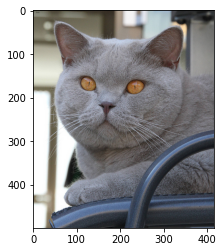

In [7]:
#Open Image and Show a Sample Image

def open_image(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

#Show Sample
plt.imshow(open_image(os.path.join(DATA_DIR, files[4])))

# **Create Custom Pytorch Dataset**

In [8]:
class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')] #Takes only the jpg files
    self.classes = list(set(parse_breed(fname) for fname in files)) #Only the unique names as classes
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx

In [9]:
#Data PreProcessing (Tensors and Normalization)

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([
                                           T.Resize(img_size),
                                           T.Pad(8, padding_mode= 'reflect'),
                                           T.RandomCrop(img_size),
                                           T.ToTensor(),
                                           T.Normalize(*imagenet_stats)
]))

In [10]:
print('Dataset size: ', len(dataset))
print('No. of Classes: ', len(dataset.classes))
print('Classes are: ', dataset.classes)

Dataset size:  7390
No. of Classes:  37
Classes are:  ['Maine Coon', 'german shorthaired', 'miniature pinscher', 'yorkshire terrier', 'pug', 'Abyssinian', 'Bengal', 'scottish terrier', 'shiba inu', 'staffordshire bull terrier', 'american bulldog', 'Egyptian Mau', 'english cocker spaniel', 'British Shorthair', 'Ragdoll', 'saint bernard', 'wheaten terrier', 'samoyed', 'Birman', 'english setter', 'boxer', 'Sphynx', 'newfoundland', 'Russian Blue', 'Bombay', 'pomeranian', 'keeshond', 'basset hound', 'japanese chin', 'beagle', 'chihuahua', 'Persian', 'Siamese', 'leonberger', 'american pit bull terrier', 'havanese', 'great pyrenees']


Label:  British Shorthair (13)


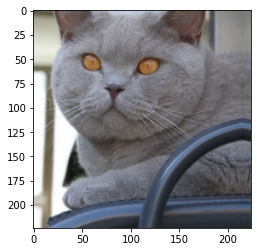

In [11]:
#Denormalize the dataset to show image from dataset

def denormalize(images, means, stds):
  if len(images.shape) == 3:
    images = images.unsqueeze(0)
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_image(img_tensor, label):
  print('Label: ', dataset.classes[label], '(' +str(label) + ')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
  plt.imshow(img_tensor)

show_image(*dataset[4])

# **Creating Training and Validation Set**

In [12]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_ds, valid_ds = random_split(dataset, [train_size, val_size])

print('Training Dataset Size: ', len(train_ds))
print('Validation Dataset Size: ', len(valid_ds))

Training Dataset Size:  6651
Validation Dataset Size:  739


In [13]:
#Load the dataset

batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle= True,
                      num_workers = 2,
                      pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size * 2,
                      num_workers = 2, pin_memory = True)

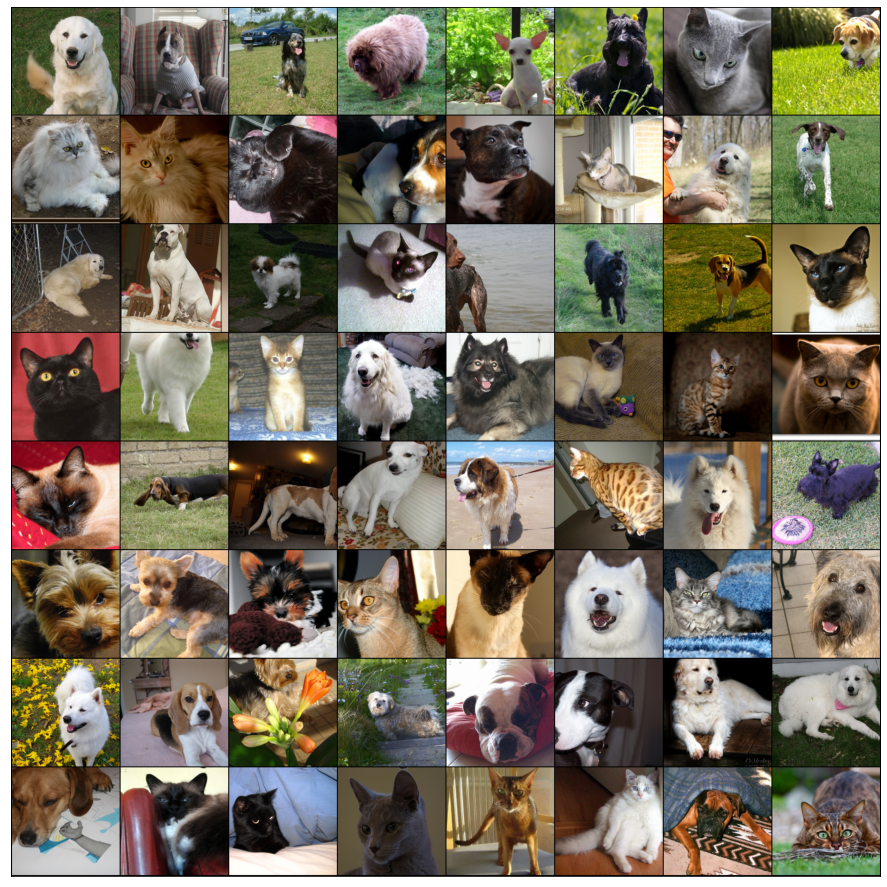

In [14]:
#Show a batch of Data from loaded data

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    images = denormalize(images[:64], *imagenet_stats)
    ax.imshow(make_grid(images, nrow= 8).permute(1, 2, 0))
    break

show_batch(train_dl)

# **Modifying Pretrained Model (ResNet34)**

**Creating Image Classification Base Class**

In [35]:
#Accuracy Mesurement

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#Image Classification Base

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)                        #Generate Prediction
    loss = F.cross_entropy(out, labels)       #Calculate Loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                        #Generate Predictions
    loss = F.cross_entropy(out, labels)       #Calculate Loss
    acc = accuracy(out, labels)               #Calculate Accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     #Mean of Loss in a epoch
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        #Mean of Accuracy in a epoch
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], {} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, "last_lr: {:.5f},".format(result['lrs'][-1])if 'lrs' in result else '',
        result['train_loss'], result['val_loss'], result['val_acc']
    ))

**Creating PetsModel (Modifying ResNet34)**

In [36]:
class PetsModel(ImageClassificationBase):
  def __init__(self, num_classes, pretrained = True):
    super().__init__()
    #Use a pretrained Model
    self.network = models.resnet34(pretrained = pretrained)
    #Replace Last Layer
    self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

  def forward(self, xb):
    return self.network(xb)

# **Using Graphics Processing Unit (GPU)**

**GPU Setup**

In [37]:
#Primary Operations (GPU Setup)

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensors to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of Batches"""
    return len(self.dl)

In [38]:
device = get_default_device()
device

device(type='cuda')

# **Create Training Loop**

In [39]:
#Evaluation Function

@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

**Fit Function**

In [40]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training Phase
    model.train()
    train_losses = []
    
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #Validation Phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

**Fit One Cycle Function**

In [41]:
#Learning Rate

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

#Fit One Cycle

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay = 0,
                  grad_clip = None, opt_func = torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  #Setup custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
  #Set up one cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs= epochs,
                                              steps_per_epoch = len(train_loader))
  
  for epoch in range(epochs):
    #Training Phase
    model.train()
    train_losses = []
    lrs = []

    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      #Record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    #Validation Phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
    
  return history

# **Training the Model on Pets Data**

In [42]:
#Load Data and Model into Chosen Device

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

model = PetsModel(len(dataset.classes), pretrained= True)
to_device(model, device);

In [43]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.03885600343346596, 'val_loss': 3.88569712638855}]

In [44]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [45]:
%%time
history += fit_one_cycle(epochs, max_lr, model,
                         train_dl, valid_dl,
                         weight_decay = weight_decay, grad_clip = grad_clip,
                         opt_func = opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00269, train_loss: 1.0506, val_loss: 5.5663, val_acc: 0.2777


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00754, train_loss: 1.3786, val_loss: 8.5989, val_acc: 0.0398


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.01000, train_loss: 1.7323, val_loss: 2.9966, val_acc: 0.2870


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00950, train_loss: 1.1639, val_loss: 2.1298, val_acc: 0.4432


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00812, train_loss: 0.8375, val_loss: 1.7883, val_acc: 0.5204


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00611, train_loss: 0.6269, val_loss: 1.0559, val_acc: 0.6877


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00389, train_loss: 0.4059, val_loss: 1.2497, val_acc: 0.6542


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00188, train_loss: 0.2457, val_loss: 0.6347, val_acc: 0.8074


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00050, train_loss: 0.1486, val_loss: 0.5832, val_acc: 0.8177


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00000, train_loss: 0.1094, val_loss: 0.5025, val_acc: 0.8460
CPU times: user 3min 28s, sys: 3min 20s, total: 6min 49s
Wall time: 12min 43s


# **Plot Training Progress**

In [46]:
#Accuracy Vs Epoch

def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy Vs No. of Epoch')

#Loss Vs Epoch

def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss Vs No. of Epoch');

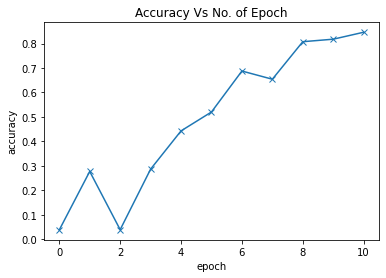

In [47]:
plot_accuracies(history)

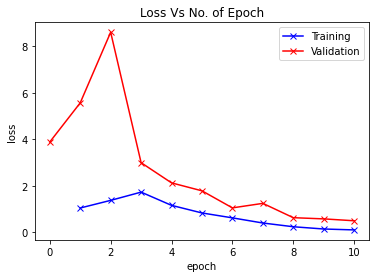

In [48]:
plot_losses(history)

# **Save Trained Model**

In [49]:
torch.save(model.state_dict(), 'oxford-iiit-transfer.pth')